# Mục mới

# Mục mới

In [ ]:
#!pip install linmix
!pip install git+https://github.com/jmeyers314/linmix


  Cloning https://github.com/jmeyers314/linmix to /tmp/pip-req-build-jsfsfh9n
  Running command git clone --filter=blob:none --quiet https://github.com/jmeyers314/linmix /tmp/pip-req-build-jsfsfh9n
  Resolved https://github.com/jmeyers314/linmix to commit 933dbb1359dcb5404cf881bfdd5cf433b0195152
  Preparing metadata (setup.py) ... done
  Created wheel for linmix: filename=linmix-0.1.0.dev1-py3-none-any.whl size=8384 sha256=5987749ba1c5bb245509c3ee347a1cd076161027e25f2c30e976ccd7bbad80cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-_2nr78ve/wheels/f9/76/d3/7be92b0ab10deccf13ffd6cfb9be4cb238e0f9c30ec0e1a37f
Successfully built linmix


In [ ]:
#================================================
# Cluster Scaling Relation: Luminosity vs Mass
#================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import linmix

In [ ]:
#================================================
# 1. Load data
#================================================

all_bin = pd.read_csv('clusters.csv', header=0)


L=all_bin['L3'] #*1e-42 erg/s                             #<=======================L
L_err=all_bin['L3_err']#*1e-42 erg/s
M=all_bin['M200']
M_err=all_bin['M_err']
Ez=all_bin['Ez']

In [ ]:
#================================================
# 2. Prepare variables for log-log fit
#================================================
x = M * Ez # <================================== redshift evolution
y = L / Ez # <================================== redshift evolution
xsig = M_err * Ez # <================================== redshift evolution
ysig = L_err / Ez # <================================== redshift evolution

X = np.log10(x)
Y = np.log10(y)
Xsig = np.log10(x + xsig) - np.log10(x)
Ysig = np.log10(y + ysig) - np.log10(y)

Run main code

In [ ]:
#================================================
# 3. Fit with LinMix (Bayesian linear regression)
#================================================
lm = linmix.LinMix(X, Y, Xsig, Ysig, xycov=None, K=2)
lm.run_mcmc(silent=True)

In [ ]:
#================================================
# 4. Extract best-fit parameters
#================================================

alpha_mean = lm.chain['alpha'].mean()
alpha_std = lm.chain['alpha'].std()
beta_mean = lm.chain['beta'].mean()
beta_std = lm.chain['beta'].std()
scatter = np.sqrt(lm.chain['sigsqr']).mean()
scatter_std = np.sqrt(lm.chain['sigsqr']).std()

print(f"Alpha = {alpha_mean:.2f} ± {alpha_std:.2f}")
print(f"Beta  = {beta_mean:.2f} ± {beta_std:.2f}")
print(f"Scatter = {scatter:.2f} ± {scatter_std:.2f}")

Alpha = 1.64 ± 0.05
Beta  = 1.23 ± 0.10
Scatter = 0.08 ± 0.04


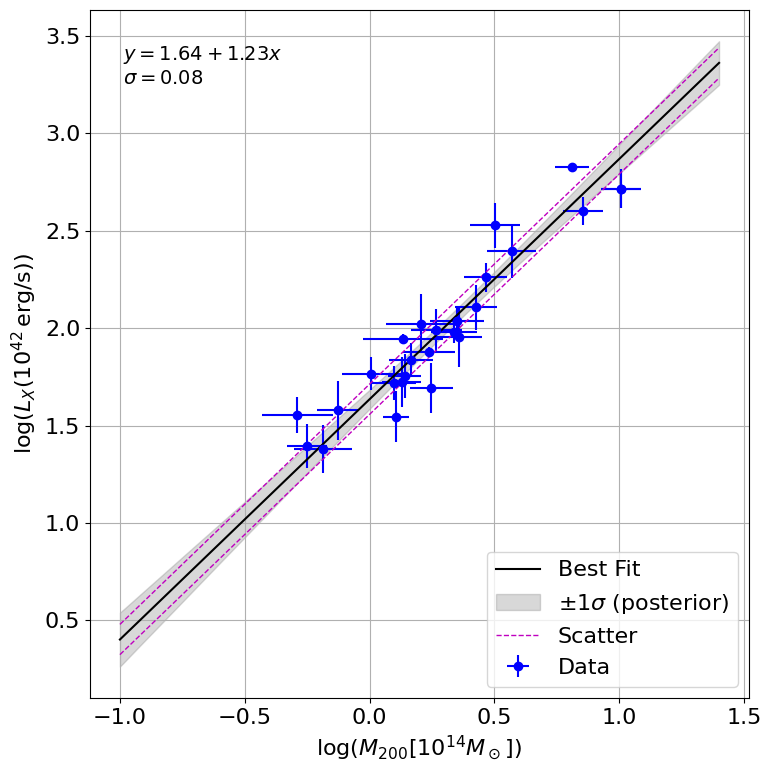

In [ ]:
#================================================
# 5. Plot data + fit
#================================================
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data points with error bars
ax.errorbar(X, Y, xerr=Xsig, yerr=Ysig, fmt='o', color='b', label='Data')

# Best-fit line
#xs = np.linspace(X.min() - 0.1, X.max() + 0.1, 100)
xs = np.arange(-1.0,1.5,0.1)
ys = alpha_mean + beta_mean * xs
ax.plot(xs, ys, 'k-', label='Best Fit')

#++++++++
# Build model predictions from the MCMC chain
y_samples = np.array([alpha + beta * xs for alpha, beta in zip(lm.chain['alpha'], lm.chain['beta'])])

# Compute percentiles for 68% confidence interval (±1σ)
y_median = np.percentile(y_samples, 50, axis=0)
y_lower  = np.percentile(y_samples, 16, axis=0)  # -1σ
y_upper  = np.percentile(y_samples, 84, axis=0)  # +1σ

plt.fill_between(xs, y_lower, y_upper, color='gray', alpha=0.3, label=r'$\pm1\sigma$ (posterior)')


#+++++++++

# Intrinsic scatter region
ax.plot(xs, ys + scatter, 'm--', lw=1, label = 'Scatter')
ax.plot(xs, ys - scatter, 'm--', lw=1)

# Labels and annotations
ax.set_xlabel(r'$\log(M_{200}  [10^{14} M_\odot])$')
ax.set_ylabel(r'$\log(L_{X} (10^{42} \, \mathrm{erg/s}))$')
#ax.set_xlim(-1.3, 1.3)
#ax.set_ylim(1, 2.2)
ax.legend()
ax.grid(True)

# Annotate results
ax.text(0.05, 0.95, f"$y = {alpha_mean:.2f} + {beta_mean:.2f}x$\n"
                    f"$\sigma = {scatter:.2f}$",
        transform=ax.transAxes, fontsize=14, verticalalignment='top')

plt.tight_layout()
plt.show()

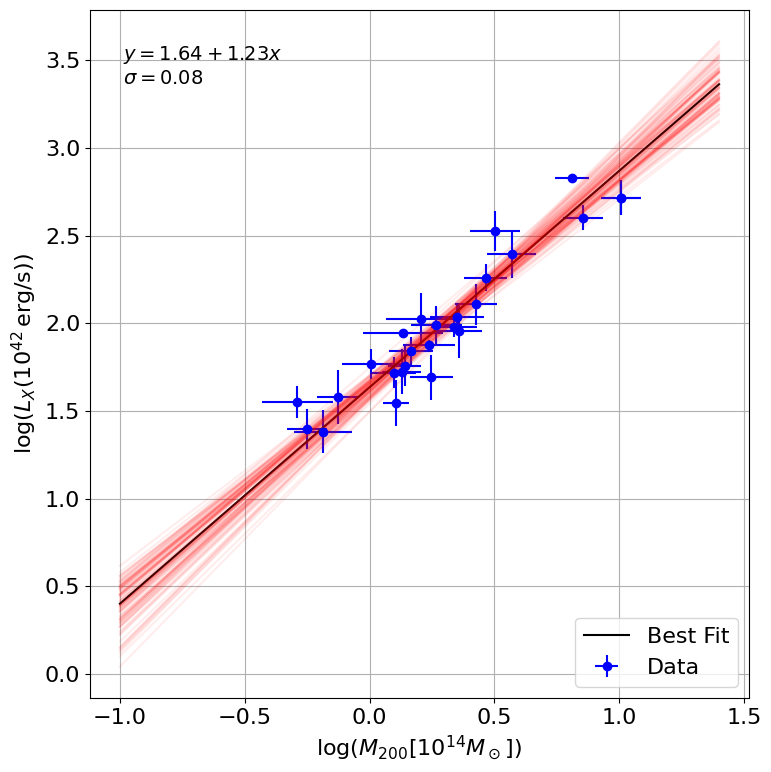

In [ ]:
#================================================
# 6. Demonstrate Bayesian fitting with MCMC chain
#================================================
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data points with error bars
ax.errorbar(X, Y, xerr=Xsig, yerr=Ysig, fmt='o', color='b', label='Data')

# Best-fit line
#xs = np.linspace(X.min() - 0.1, X.max() + 0.1, 100)
xs = np.arange(-1.0,1.5,0.1)
ys = alpha_mean + beta_mean * xs
ax.plot(xs, ys, 'k-', label='Best Fit')

# Random samples from posterior

for i in range(0, len(lm.chain), 100):
    yi = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
    ax.plot(xs, yi, color='r', alpha=0.07)

# Labels and annotations
ax.set_xlabel(r'$\log(M_{200}  [10^{14} M_\odot])$')
ax.set_ylabel(r'$\log(L_{X} (10^{42} \, \mathrm{erg/s}))$')
#ax.set_xlim(-1.3, 1.3)
#ax.set_ylim(1, 2.2)
ax.legend()
ax.grid(True)

# Annotate results
ax.text(0.05, 0.95, f"$y = {alpha_mean:.2f} + {beta_mean:.2f}x$\n"
                    f"$\sigma = {scatter:.2f}$",
        transform=ax.transAxes, fontsize=14, verticalalignment='top')

plt.tight_layout()
plt.show()